#  Is a patient falling from the bed or not?

- This project classifies patients falling from the bed or not (binary classification) by using deep learning models (ResNet) and fast.ai library.

- This project is based on the project 'Is it a bird? Creating a model from your own data'(https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) by Jeremy Howard, which is a resource of the lecture 1. Getting Started of 'Practical Deep Learning for Coders 2022' course(https://course.fast.ai/).

- **Introduction**:
  When I worked as a Registered Nurse in South Korea, one of my duties was to watch elderly patients not to fall from the bed, which can cause a mild injury up to death. The fall accident can happen anytime while a medical staff is working with other tasks for a while, even though the medical staff has been paying attention to the patient to prevent the fall. There are a lot of ways to prevent a patient's fall, one of them is detecting the patient's movements and alerting medical staff right before or when the patient is about to fall from the bed. This project is based on this concept, which can show the minimal performance.

- **Limitations**: 
  - Data: Some of images of a patient falling from the bed are correctly collected, however, some of them are not. Similarly, some of images of a patient in the bed are not collected correctly.
  - Performance: This project cannot perform an exact prediction on a patient's fall from the bed. 

- **Future Works**:
  - Data: After collecting images, the labels of the images should be reviewed by human or a healthcare providers. 
  - Performance: In the future work, the performance on predicting on a patient's fall from the bed can be imporved by using a multi-class classification, which is classifying a patient right before falling from the bed, falling from the bed, already fallen from the bed, in the bed.



In [1]:
!pip install -Uqq fastai duckduckgo_search

     |████████████████████████████████| 240 kB 20.7 MB/s 
     |████████████████████████████████| 96 kB 4.0 MB/s 
     |████████████████████████████████| 62 kB 445 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "a patient falling from the bed photos".
2. Use DuckDuckGo to search for images of "a patient in the bed photos".
3. Fine-tune a pretrained neural network to recognize these two groups.
4. Try running this model on a picture of a patient falling from the bed and see if it works.

# Step 1: Download images of a patient falling from the bed and a patient in the bed

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
urls_falling = search_images("a patient falling from the bed photos", max_images=1)
urls_falling[0]

Searching for 'a patient falling from the bed photos'


'https://www.healthworkscollective.com/wp-content/uploads/2012/10/PatientFall.tif'

In [4]:
urls_not_falling = search_images("a patient in the bed photos", max_images=1)
urls_not_falling[0]

Searching for 'a patient in the bed photos'


'http://share.upmc.com/wp-content/uploads/2015/04/patient-in-bed.jpg'

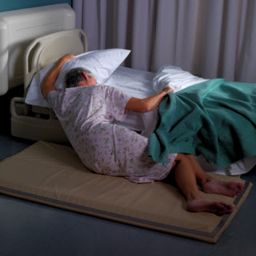

In [5]:
from fastdownload import download_url
from fastai.vision.all import *

dest = 'falling.jpg'
download_url(urls_falling[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)

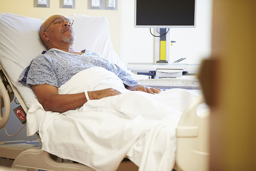

In [6]:
dest_2 = 'not-falling.jpg'
download_url(urls_not_falling[0], dest_2, show_progress=False)
Image.open(dest_2).to_thumb(256, 256)

In [8]:
from time import sleep

def make_dataset(path, file_name, search):
  dest = (path/file_name)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{search} photo'))
  sleep(10) # Pause between searches to avoid over-loading server
  download_images(dest, urls=search_images(f'{search} sun photo'))
  sleep(10)
  download_images(dest, urls=search_images(f'{search} shade photo'))
  sleep(10)
  resize_images(path/file_name, max_size=400, dest=path/file_name)

path = Path('falling_or_not')
make_dataset(path, 'falling', 'a patient falling from the bed')
make_dataset(path, 'not-falling', 'a patient in the bed')

Searching for 'a patient falling from the bed photo'
Searching for 'a patient falling from the bed sun photo'
Searching for 'a patient falling from the bed shade photo'
Searching for 'a patient in the bed photo'
Searching for 'a patient in the bed sun photo'
Searching for 'a patient in the bed shade photo'


# Step 2: Train our model

Some photos might not download correctly which would cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

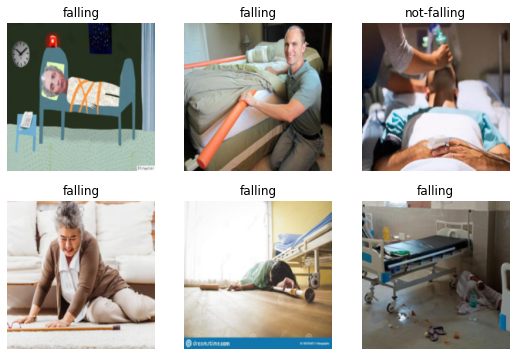

In [20]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.236919,0.720103,0.250000,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.497231,0.727149,0.211538,00:26
1,0.414031,0.473702,0.115385,00:29
2,0.318029,0.343789,0.096154,00:30


This patient is falling.
Probability this patient is falling: 0.9724


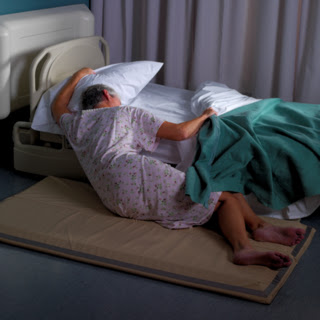

In [22]:
falling_image = PILImage.create('falling.jpg')
is_falling, _, probs = learn.predict(falling_image)
print(f"This patient is {is_falling}.")
print(f"Probability this patient is falling: {probs[0]:.4f}")
falling_image

In [23]:
download_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRmSCXswvdyIn_FKs3rDvoDJ0Ea7VCobb0xyg&usqp=CAU', 'falling-img-from-internet.jpg', show_progress=False)


Path('falling-img-from-internet.jpg')

This patient is falling.
Probability this patient is falling: 0.6297


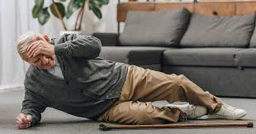

In [24]:
is_falling, _, probs = learn.predict('falling-img-from-internet.jpg')
print(f"This patient is {is_falling}.")
print(f"Probability this patient is falling: {probs[0]:.4f}")
Image.open('falling-img-from-internet.jpg').to_thumb(256,256)